In [1]:
from unit_decision import *

#Delray Beach, FL
fdid = '06172'
state = 'FL'
firecares_id = '79592'

#Note I lumped both engines and Truck/Aerial into one category called "Suppression"
unit_type_mapping = {'ALS':['ALS'], 'Suppression':['Engine','Truck/Aerial']}

#Exclude stations
exclude_stations = ['116']

#Specifiying units to ignore
bad_units = ['EMS111', 'R2111']

#Specifying fields that must not contain NaNs
drop_subset=['address.first_due','unit_status.dispatched.timestamp','unit_status.available.timestamp']

#Creating a department object and loading methods to populate its fields
dep = department(firecares_id,fdid,state,load_all=True,unit_type_mapping=unit_type_mapping,bad_units=bad_units, exclude_stations=exclude_stations)
dep.cleaner(drop_subset)
dep.from_station()
dep.first_due_analysis()
dep.station_builder()

#Don't worry too much about this. I tried several distribution fitting approaches for the DA class
p = (10,50,90)
weights = (0.3,0.4,0.3)
dep.build_distribution(p,weights)
dep.build_lognorm()

['Suppression', 'ALS']
Acquiring department's jurisdictional boundary...
Done! 

Cleaning the apparatus dataframe...
Done! 

Determining if units were sent from their station...
Getting information about units that are busy when units are dispatched...
Running the algorithm to find units active at the start of each incident


  0%|          | 0/5942 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running the algorithm to find units active at the start of each incident


  0%|          | 0/10293 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Done! 



In [5]:
dep.df.unit_type

0        Suppression
1        Suppression
2        Suppression
3        Suppression
4        Suppression
            ...     
10288            ALS
10289            ALS
10290            ALS
10291            ALS
10292            ALS
Name: unit_type, Length: 16235, dtype: object

In [22]:
# Example usage for optimization tool
dep.optimizer('Suppression', 2, dep.quantile)
print(dep.best) #prints the list of stations that should get new units
print(dep.improvement) #Prints the expected improvement (in seconds) to global response time distribution

['113' '111']
16.189594430863508


In [23]:
dep.optimizer('Suppression', 2)
print(dep.best)
print(dep.improvement)

['113' '111']
8.357889409337758


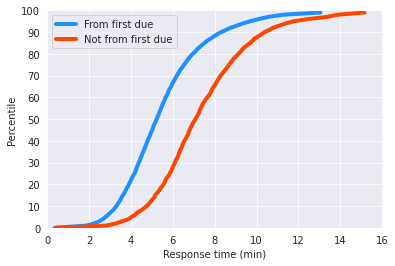

In [6]:
plt.rcParams['figure.figsize'] = [6,4]
als = dep.df[dep.df['unit_type'] == 'ALS'].reset_index(drop=True)
from_due = np.array(als[als['from_first_due']==True]['extended_data.response_duration'])/60
not_from_due = np.array(als[als['from_first_due']==False]['extended_data.response_duration'])/60

percentiles = np.arange(100)
plt.plot(np.percentile(from_due, percentiles),percentiles, color='dodgerblue', linewidth=4)
plt.plot(np.percentile(not_from_due, percentiles),percentiles, color='orangered', linewidth=4)
plt.xlabel('Response time (min)')
plt.ylabel('Percentile')
plt.yticks(np.linspace(0,100,11))
plt.ylim([0,100])
plt.xlim([0,16])
plt.legend(['From first due', 'Not from first due'])
plt.savefig('dep_cdf')


In [66]:
dep.station_list

array(['111', '112', '113', '114', '115', '116'], dtype=object)

5.0:35.3920041536864
6.0:58.93386243386243
6.0:2.431239388794552
7.0:45.11734693877548
5.0:25.569552238805954
7.0:29.257142857142867
6.0:11.37448979591835
6.0:52.33519553072625
4.0:59.21550463188686
7.0:34.514285714285734


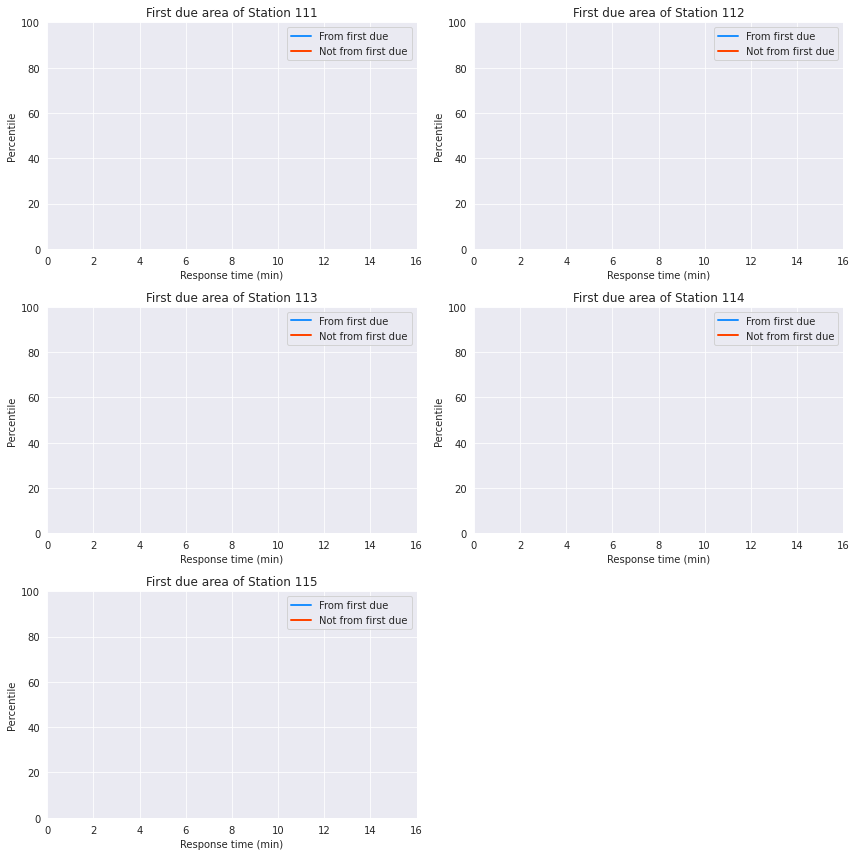

In [7]:
unit_type = 'ALS'


alias = [str(i) for i in range(111,118)]

q = np.arange(100)
plt.rcParams['figure.figsize'] = [12,12]
for i,station_num in enumerate(dep.station_list):
    plt.subplot(3,2,i+1)
    send = dep.station_dict[station_num].sent_full[unit_type]
    nsend = dep.station_dict[station_num].not_sent_full[unit_type]
    
    print(str(np.floor(np.mean(send)/60))+':'  + str(np.mean(send)%60)  )
    print(str(np.floor(np.mean(nsend)/60))+':' + str(np.mean(nsend)%60) )
    
    plt.plot(np.percentile(send,q),q, color='dodgerblue',linewidth=2)
    plt.plot(np.percentile(nsend,q),q, color='orangered',linewidth=2)
    plt.xlabel('Response time (min)')
    plt.ylabel('Percentile')
    plt.title('First due area of Station '+ alias[i])
    plt.xlim([0,16])
    plt.ylim([0,100])
    plt.tight_layout()
    plt.legend(['From first due', 'Not from first due' ])
    
    plt.savefig('station_cdfs')
    

    

380.7193396226415
401.63291139240505
384.6969453376206
454.6204379562044
367.3424242424242
516.5025380710659
386.9688958009331
468.2162162162162
320.42137877614255
489.30833333333334


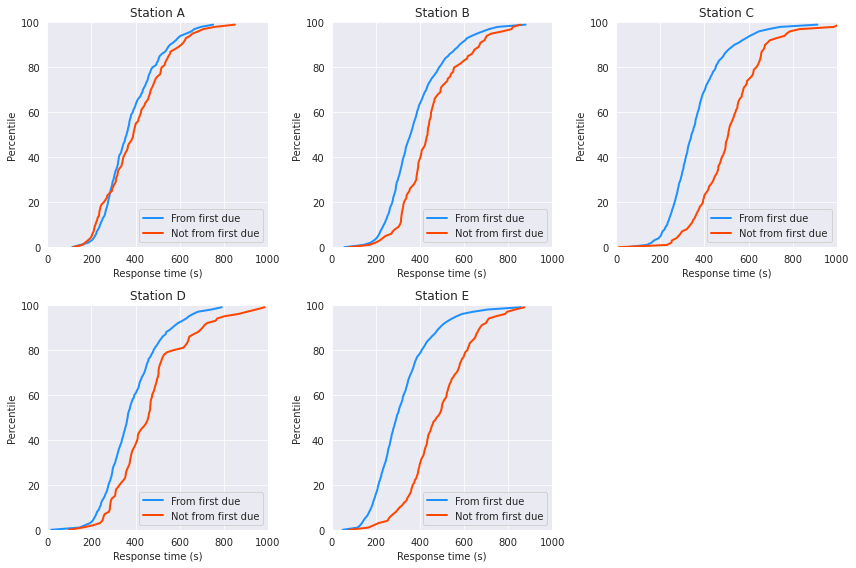

In [8]:
unit_type = 'Suppression'


alias = ['A', 'B', 'C', 'D', 'E', 'F']

q = np.arange(100)
plt.rcParams['figure.figsize'] = [12,8]
for i,station_num in enumerate(dep.station_list):
    plt.subplot(2,3,i+1)
    send = dep.station_dict[station_num].sent_full[unit_type]
    nsend = dep.station_dict[station_num].not_sent_full[unit_type]
    print(np.mean(send))
    print(np.mean(nsend))
    
    plt.plot(np.percentile(send,q),q, color='dodgerblue',linewidth=2)
    plt.plot(np.percentile(nsend,q),q, color='orangered',linewidth=2)
    plt.xlabel('Response time (s)')
    plt.ylabel('Percentile')
    plt.title('Station '+ alias[i])
    plt.xlim([0,1000])
    plt.ylim([0,100])
    plt.tight_layout()
    plt.legend(['From first due', 'Not from first due' ])
    
#     plt.savefig(figloc+'firediff')
    

In [74]:
ndue = als[als['from_first_due']==False].reset_index(drop=True)
np.sum(ndue['num_required']>1)/len(ndue)



0.6455129997204361

In [73]:
len(ndue)

10731

In [ ]:
dep.df['num_active'].value_counts()

In [ ]:
figloc = './DA_project

In [ ]:
snum = '116'
df = dep.station_dict[snum].df
df = df[df['unit_type']=='Suppression']
no_units = df[df['num_active'] == 0]
np.sum(no_units['station']==snum)/len(no_units)

In [ ]:
dep.station_dict[station_num].num_required[unit_type]

NameError: name 'figloc' is not defined

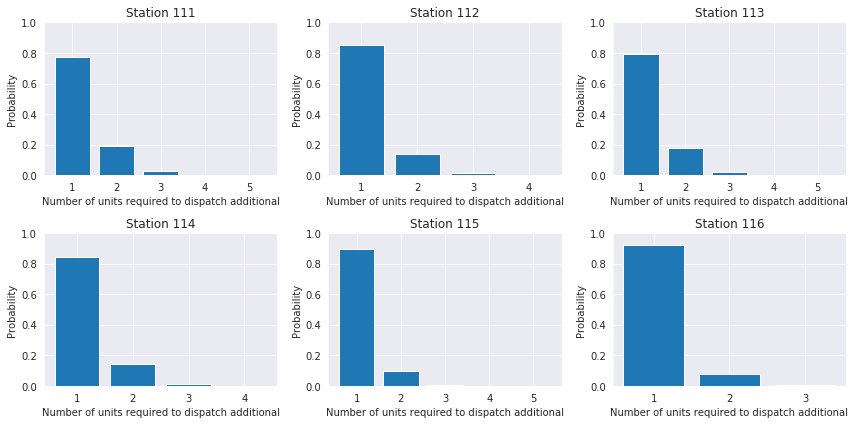

In [75]:
plt.rcParams['figure.figsize'] = [12,6]
unit_type = 'ALS'

for j,station_num in enumerate(dep.station_list):
    plt.subplot(2,3,j+1)
    vals = np.arange(1,len(dep.station_dict[station_num].num_required[unit_type])+1)
    vals= [str(i) for i in vals]
    plt.bar(vals,dep.station_dict[station_num].num_required[unit_type])
    plt.ylim(0,1)
    plt.xlabel('Number of units required to dispatch additional')
    plt.ylabel('Probability')
    plt.title('Station '+ alias[j])
    plt.tight_layout()
plt.savefig(figloc+'alsbar')

In [ ]:
plt.rcParams['figure.figsize'] = [12,6]
unit_type = 'Suppression'

for j,station_num in enumerate(dep.station_list):
    plt.subplot(2,3,j+1)
    vals = np.arange(1,len(dep.station_dict[station_num].num_required[unit_type])+1)
    vals= [str(i) for i in vals]
    plt.bar(vals,dep.station_dict[station_num].num_required[unit_type])
    plt.ylim(0,1)
    plt.xlabel('Number of units required to dispatch additional')
    plt.ylabel('Probability')
    plt.title('Station '+ alias[j])
    plt.tight_layout()
plt.savefig(figloc+'firebar')

In [ ]:
dep.optimizer('ALS', 2, dep.mean_calc)
dep.best

In [ ]:
dep.impor

In [ ]:
dep.first_due_probs

In [ ]:
unit_type = 'ALS'
for i, station_num in enumerate(dep.station_list):
    print(dep.station_dict[station_num].send_given_available)
#     print(dep.station_dict[station_num].send_probs[unit_type]/dep.station_dict[station_num].first_due_probs[unit_type])

In [ ]:
dep.station_dict['116'].send_given_available

In [ ]:
dep.df[dep.df['unit_type']=='Truck/Aerial']['unit_id'].unique()

In [ ]:
#Lognormal fitting

NameError: name 'figloc' is not defined

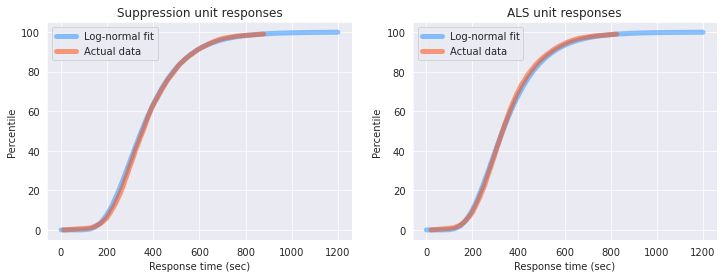

In [9]:
plt.rcParams['figure.figsize'] = [12,4]
for i,unit_type in enumerate(dep.unit_types):
    plt.subplot(1,2,i+1)
    x = np.linspace(1,1200)

    plt.plot(x,dep.lognorm[unit_type].cdf(x)*100, color='dodgerblue', linewidth=5, alpha=0.5)
    q = np.arange(100)
    real_times = np.percentile(dep.df[dep.df['unit_type'] == unit_type]['extended_data.response_duration'],q)
    plt.plot(real_times,q,color='orangered',linewidth=5, alpha=0.5)

    plt.legend(['Log-normal fit', 'Actual data'])
    plt.title(unit_type +' unit responses')
    plt.xlabel('Response time (sec)')
    plt.ylabel('Percentile')
    
    
plt.savefig(figloc+'lognorm')

NameError: name 'figloc' is not defined

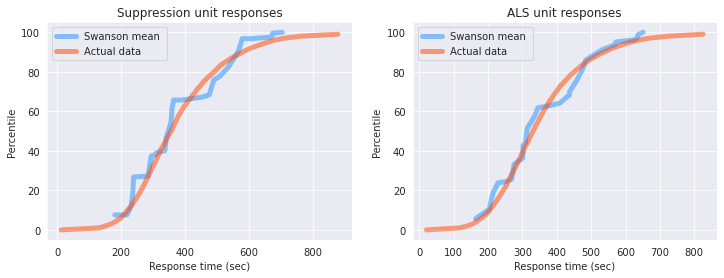

In [10]:
plt.rcParams['figure.figsize'] = [12,4]
for i,unit_type in enumerate(dep.unit_types):
    plt.subplot(1,2,i+1)
    x = np.linspace(1,1200)
    idx = np.argsort(dep.times[unit_type])
    times = dep.times[unit_type][idx]
    probs = dep.probs[unit_type][idx]
    cum_prob = np.cumsum(probs)
    
    plt.plot(times,cum_prob*100, color='dodgerblue', linewidth=5, alpha=0.5)
    q = np.arange(100)
    real_times = np.percentile(dep.df[dep.df['unit_type'] == unit_type]['extended_data.response_duration'],q)
    plt.plot(real_times,q,color='orangered',linewidth=5, alpha=0.5)

    plt.legend(['Swanson mean ', 'Actual data'])
    plt.xlabel('Response time (sec)')
    plt.ylabel('Percentile')
    plt.title(unit_type +' unit responses')

    
plt.savefig(figloc+'swanson')

In [ ]:
p = (10,50,90)
weights = (0.3,0.4,0.3)
dep.build_distribution(p,weights)
plt.rcParams['figure.figsize'] = [12,4]
for i,unit_type in enumerate(dep.unit_types):
    plt.subplot(1,2,i+1)
    x = np.linspace(1,1200)
    idx = np.argsort(dep.times[unit_type])
    times = dep.times[unit_type][idx]
    probs = dep.probs[unit_type][idx]
    cum_prob = np.cumsum(probs)
    
    plt.plot(times,cum_prob*100, color='dodgerblue', linewidth=5, alpha=0.5)
    q = np.arange(100)
    real_times = np.percentile(dep.df[dep.df['unit_type'] == unit_type]['extended_data.response_duration'],q)
    plt.plot(real_times,q,color='orangered',linewidth=5, alpha=0.5)

    plt.legend(['Swanson mean ', 'Actual data'])
    plt.title(unit_type +' unit responses')
    plt.xlabel('Response time (sec)')
    plt.ylabel('Percentile')
    
plt.savefig(figloc+'swanson')

In [ ]:
dep.monte_carlo()

In [ ]:
plt.rcParams['figure.figsize'] = [12,4]
for i,unit_type in enumerate(dep.unit_types):
    plt.subplot(1,2,i+1)
    x = np.linspace(1,1200)
    q = np.arange(100)
    mc_times = np.percentile(dep.mc_times[unit_type],q)
    plt.plot(mc_times,q, color='dodgerblue', linewidth=5, alpha=0.5)
    
    real_times = np.percentile(dep.df[dep.df['unit_type'] == unit_type]['extended_data.response_duration'],q)
    plt.plot(real_times,q,color='orangered',linewidth=5, alpha=0.5)

    plt.legend(['Monte-Carlo result', 'Actual data'])
    plt.xlabel('Response time (sec)')
    plt.ylabel('Percentile')
    plt.title(unit_type +' unit responses')
    
plt.savefig(figloc+'mccomp')

# Making a plot to validate the assumption that travel times for trucks and engines are the same

In [ ]:
q = np.arange(100)
truck_stations = ['111','115','116']
plt.rcParams['figure.figsize'] = [15,5]
fig = plt.figure()
for i,station_num in enumerate(truck_stations):
    engine = dep.station_dict[station_num].sent_full['Engine']
    truck = dep.station_dict[station_num].sent_full['Truck/Aerial']
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(np.percentile(engine,q),q, color='dodgerblue', label='Engine', linewidth=3)
    ax.plot(np.percentile(truck,q),q, color='orangered', label='Truck', linewidth=3)
    ax.set_xlabel('Travel time (sec)')
    ax.set_ylabel('Percentile')
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
    


    


    
    


In [ ]:
sent = dep.station_dict['111'].sent_full['Engine']
not_sent = dep.station_dict['111'].not_sent_full['Engine']
q = np.arange(100)

plt.plot(np.percentile(sent,q),q)
plt.plot(np.percentile(not_sent,q),q)

In [ ]:
#Making a cdf to compare times
unit_type = 'ALS'
idx = np.argsort(dep.times[unit_type])
times = dep.times[unit_type][idx]
probs = dep.probs[unit_type][idx]
cum_prob = np.cumsum(probs)
plt.plot(times,cum_prob)

q = np.arange(100)
quantiles = np.percentile(dep.df[dep.df['unit_type'] == unit_type]['extended_data.response_duration'],q)


plt.plot(quantiles,q/100)